In [1]:
##IMPORTS
#Basics
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os # create directories in the local filesystem
from tqdm import tqdm # plot progress bars
import plotly.express as px

#PyTorch
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import  DataLoader
from torch import nn


import torch.optim as optim
import torch.nn.functional as F

#Pytoprch lightning


#For Optuna (Hyperparameters search)
import optuna
from optuna.integration import PyTorchLightningPruningCallback

#Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# For latent space exploration
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Models definitions and training models


C:\Users\hilar\anaconda3\envs\NNDL_torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set seeds for reproducibility (PyTorch, Python, Numpy)
matricola = 2013031
torch.manual_seed(matricola)
random.seed(matricola)
np.random.seed(matricola)

In [3]:
### Download the data and create dataset
data_dir = '../dataset'
# With these commands the train and test datasets, respectively, are downloaded 
# automatically and stored in the local "data_dir" directory.
train_dataset = torchvision.datasets.FashionMNIST(data_dir, train=True, download=False)
test_dataset  = torchvision.datasets.FashionMNIST(data_dir, train=False, download=False)

In [4]:
# In this case the train_transform and test_transform are the same, 
# but we keep them separate for potential future updates
train_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Set the train transform
train_dataset.transform = train_transform
# Set the test transform
test_dataset.transform = test_transform

### Define train dataloader
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
### Define test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [ ]:
encoded_space_dim = 2
max_epochs        = 10
learning_rate     = 1e-3
regularization    = 0.

In [ ]:
# Initialize the autoencoder
AE = model.Autoencoder(encoded_space_dim)

In [ ]:
### Define the loss function for reconstruction
loss_fn = nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
params_to_optimize = [
    {'params': AE.encoder.parameters()},
    {'params': AE.decoder.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=learning_rate, weight_decay=regularization)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

#Send model to device
AE.to(device)

In [ ]:
train_loss, test_loss = AE.training_cycle(device,
                                train_dataloader,
                                test_dataloader,
                                loss_fn,
                                optim,
                                max_epochs,
                                test_dataset,
                                encoded_space_dim,
                                plot = True,
                                keep_plots = False,
                                keep_model=False,
                                verbose=True)

In [5]:
"""
Network Architectures
The following are the discriminator and generator architectures
"""

class discriminator(nn.Module):
    def __init__(self):
        super(discriminator, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 1)
        self.activation = nn.LeakyReLU(0.1)

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return nn.Sigmoid()(x)


class generator(nn.Module):
    def __init__(self):
        super(generator, self).__init__()
        self.fc1 = nn.Linear(128, 1024)
        self.fc2 = nn.Linear(1024, 2048)
        self.fc3 = nn.Linear(2048, 784)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        x = x.view(-1, 1, 28, 28)
        return nn.Tanh()(x)

In [7]:
"""
Determine if any GPUs are available
"""
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


"""
Hyperparameter settings
"""
epochs = 100
lr = 2e-4
batch_size = 64
loss = nn.BCELoss()

In [8]:
# Model
G = generator().to(device)
D = discriminator().to(device)

G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

In [8]:
# """
# Image transformation and dataloader creation
# Note that we are training generation and not classification, and hence
# only the train_loader is loaded
# """
# # Transform
# transform = transforms.Compose([transforms.ToTensor(),
#                                 transforms.Normalize((0.5,), (0.5,))])
# # Load data
# train_set = datasets.MNIST('mnist/', train=True, download=True, transform=transform)
# train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

In [9]:
"""
Network training procedure
Every step both the loss for disciminator and generator is updated
Discriminator aims to classify reals and fakes
Generator aims to generate images as realistic as possible

"""
for epoch in range(epochs):
    for idx, (imgs, _) in enumerate(train_dataloader):
        idx += 1

        # Training the discriminator
        # Real inputs are actual images of the MNIST dataset
        # Fake inputs are from the generator
        # Real inputs should be classified as 1 and fake as 0
        real_inputs = imgs.to(device)
        real_outputs = D(real_inputs) #Discrimination on real images
        real_label = torch.ones(real_inputs.shape[0], 1).to(device)

        noise = (torch.rand(real_inputs.shape[0], 128) - 0.5) / 0.5
        noise = noise.to(device)
        fake_inputs = G(noise)        #Generation of false images
        fake_outputs = D(fake_inputs) #Discrimination on false images
        fake_label = torch.zeros(fake_inputs.shape[0], 1).to(device)

        outputs = torch.cat((real_outputs, fake_outputs), 0)
        targets = torch.cat((real_label, fake_label), 0)

        D_loss = loss(outputs, targets)
        D_optimizer.zero_grad()
        D_loss.backward()
        D_optimizer.step()

        # Training the generator
        # For generator, goal is to make the discriminator believe everything is 1
        noise = (torch.rand(real_inputs.shape[0], 128)-0.5)/0.5
        noise = noise.to(device)

        fake_inputs = G(noise)         #Generate images
        fake_outputs = D(fake_inputs)  #Classify fake images
        fake_targets = torch.ones([fake_inputs.shape[0], 1]).to(device)
        G_loss = loss(fake_outputs, fake_targets)
        G_optimizer.zero_grad()
        G_loss.backward()
        G_optimizer.step()

        if idx % 100 == 0 or idx == len(train_dataloader):
            print('Epoch {} Iteration {}: discriminator_loss {:.3f} generator_loss {:.3f}'.format(epoch, idx, D_loss.item(), G_loss.item()))

    if (epoch+1) % 10 == 0:
        torch.save(G, 'Generator_epoch_{}.pth'.format(epoch))
        print('Model saved.')

Epoch 0 Iteration 100: discriminator_loss 0.673 generator_loss 0.939
Epoch 0 Iteration 200: discriminator_loss 0.665 generator_loss 0.764
Epoch 0 Iteration 235: discriminator_loss 0.631 generator_loss 0.782
Epoch 1 Iteration 100: discriminator_loss 0.659 generator_loss 1.100
Epoch 1 Iteration 200: discriminator_loss 0.617 generator_loss 0.787
Epoch 1 Iteration 235: discriminator_loss 0.645 generator_loss 0.720
Epoch 2 Iteration 100: discriminator_loss 0.642 generator_loss 0.816
Epoch 2 Iteration 200: discriminator_loss 0.696 generator_loss 0.691
Epoch 2 Iteration 235: discriminator_loss 0.682 generator_loss 0.849
Epoch 3 Iteration 100: discriminator_loss 0.534 generator_loss 0.848
Epoch 3 Iteration 200: discriminator_loss 0.799 generator_loss 0.881
Epoch 3 Iteration 235: discriminator_loss 0.754 generator_loss 0.964
Epoch 4 Iteration 100: discriminator_loss 0.554 generator_loss 0.872
Epoch 4 Iteration 200: discriminator_loss 0.677 generator_loss 0.787
Epoch 4 Iteration 235: discriminat

Epoch 39 Iteration 100: discriminator_loss 0.691 generator_loss 0.729
Epoch 39 Iteration 200: discriminator_loss 0.674 generator_loss 0.762
Epoch 39 Iteration 235: discriminator_loss 0.660 generator_loss 0.809
Model saved.
Epoch 40 Iteration 100: discriminator_loss 0.686 generator_loss 0.758
Epoch 40 Iteration 200: discriminator_loss 0.695 generator_loss 0.752
Epoch 40 Iteration 235: discriminator_loss 0.691 generator_loss 0.691
Epoch 41 Iteration 100: discriminator_loss 0.695 generator_loss 0.777
Epoch 41 Iteration 200: discriminator_loss 0.712 generator_loss 0.720
Epoch 41 Iteration 235: discriminator_loss 0.714 generator_loss 0.734
Epoch 42 Iteration 100: discriminator_loss 0.679 generator_loss 0.779
Epoch 42 Iteration 200: discriminator_loss 0.711 generator_loss 0.750
Epoch 42 Iteration 235: discriminator_loss 0.685 generator_loss 0.731
Epoch 43 Iteration 100: discriminator_loss 0.714 generator_loss 0.759
Epoch 43 Iteration 200: discriminator_loss 0.692 generator_loss 0.772
Epoch 4

Epoch 78 Iteration 100: discriminator_loss 0.708 generator_loss 0.752
Epoch 78 Iteration 200: discriminator_loss 0.693 generator_loss 0.712
Epoch 78 Iteration 235: discriminator_loss 0.694 generator_loss 0.778
Epoch 79 Iteration 100: discriminator_loss 0.679 generator_loss 0.760
Epoch 79 Iteration 200: discriminator_loss 0.701 generator_loss 0.720
Epoch 79 Iteration 235: discriminator_loss 0.705 generator_loss 0.758
Model saved.
Epoch 80 Iteration 100: discriminator_loss 0.700 generator_loss 0.709
Epoch 80 Iteration 200: discriminator_loss 0.667 generator_loss 0.729
Epoch 80 Iteration 235: discriminator_loss 0.685 generator_loss 0.732
Epoch 81 Iteration 100: discriminator_loss 0.692 generator_loss 0.737
Epoch 81 Iteration 200: discriminator_loss 0.650 generator_loss 0.766
Epoch 81 Iteration 235: discriminator_loss 0.663 generator_loss 0.780
Epoch 82 Iteration 100: discriminator_loss 0.709 generator_loss 0.704
Epoch 82 Iteration 200: discriminator_loss 0.697 generator_loss 0.705
Epoch 8

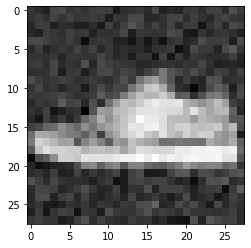

In [17]:
fake = G(noise)[0].squeeze().detach().numpy()
plt.imshow(fake, cmap='gist_gray')

In [16]:
fake_targets

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
      

In [25]:
real_outputs.shape[0]

96

In [27]:
noise.shape

torch.Size([96, 128])

In [30]:
outputs.shape

torch.Size([192, 1])

In [28]:
fake_label

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
      